# Annex 96 Common Exercise 1 – Quick Start Notebook

This notebook provides a minimal end-to-end setup for:


1. Cloning the CE1 GitHub repository
2. Understanding the TX & VT datasets
3. Visualizing the daily reference district load
4. Running a simple baseline battery RBC controller
5. Evaluating KPIs

If you run into issues, please reach out on the Annex 96 Slack (Common Exercise channel).


# 1. Install Required Dependencies

This Common Exercise uses a **specific version of CityLearn included inside this repository**.

👉 **Do NOT install CityLearn using `pip install citylearn`.**  
This will install a different version that is **not compatible** with the Common Exercise and will cause errors.

Instead, please install all dependencies directly from the repository’s `requirements.txt` file.





### Clone the Common Exercise repository


In [1]:
!git clone https://github.com/kkaspar10/annex96_common_exercise_1.git

Cloning into 'annex96_common_exercise_1'...
remote: Enumerating objects: 9377, done.
remote: Counting objects: 100% (307/307), done.
remote: Compressing objects: 100% (262/262), done.
remote: Total 9377 (delta 93), reused 188 (delta 31), pack-reused 9070 (from 1)
Receiving objects: 100% (9377/9377), 317.29 MiB | 2.15 MiB/s, done.
Resolving deltas: 100% (5248/5248), done.
Updating files: 100% (1311/1311), done.


### Install required Python packages

In [ ]:
!pip install -r annex96_common_exercise_1/requirements.txt

## 2. Dataset Overview (TX vs VT)

The Common Exercise uses two scenarios:

### 🔵 Texas (TX) – cooling dominated  
- Training: **August**  
- Testing: **September**  
- Higher solar generation, strong cooling loads.

### 🔵 Vermont (VT) – heating dominated  
- Training: **January**  
- Testing: **February**  
- High heating loads, low PV in winter.

Each climate folder contains:

- `schema.json`  
- 25 ResStock buildings  
- Pre-computed district reference load  
- All data handled automatically by CityLearn




In [1]:
import sys
from pathlib import Path

# 1) Find repo root = folder that contains "citylearn/"
HERE = Path.cwd()
REPO_DIR = None
for p in [HERE] + list(HERE.parents):
    if (p / "citylearn").exists():
        REPO_DIR = p
        break

if REPO_DIR is None:
    raise FileNotFoundError(
        "Couldn't find the repo root (a folder containing 'citylearn'). "
        "Make sure you cloned the repo and opened the notebook from somewhere inside it."
    )

# 2) Force local CityLearn (repo version)
sys.path.insert(0, str(REPO_DIR))
import citylearn
print("✅ citylearn loaded from:", citylearn.__file__)
print("✅ repo root:", REPO_DIR)

# 3) Dataset paths
CLIMATE = "VT"  # "TX" or "VT"
DATASET_DIR = REPO_DIR / "data" / "datasets" / f"annex96_ce1_{CLIMATE.lower()}_neighborhood"
SCHEMA_PATH = DATASET_DIR / "schema.json"

print("\nClimate:", CLIMATE)
print("Dataset directory:", DATASET_DIR, " | exists:", DATASET_DIR.exists())
print("Schema path:", SCHEMA_PATH, " | exists:", SCHEMA_PATH.exists())


✅ citylearn loaded from: /home/ava_mohammadi/PhD/annex96_common_exercise_1/citylearn/__init__.py
✅ repo root: /home/ava_mohammadi/PhD/annex96_common_exercise_1

Climate: VT
Dataset directory: /home/ava_mohammadi/PhD/annex96_common_exercise_1/data/datasets/annex96_ce1_vt_neighborhood  | exists: True
Schema path: /home/ava_mohammadi/PhD/annex96_common_exercise_1/data/datasets/annex96_ce1_vt_neighborhood/schema.json  | exists: True


## 3. District Load Target

Each day, the Annex 96 CE defines a **constant district load target** equal to the average aggregated demand of all buildings for the each day.

Controllers attempt to track this reference profile.

Below is the reference load plot for the selected climate (TX or VT).

![District Target](../assets/images/district_load_target.png)



In [2]:
import pandas as pd

district_target_df = pd.read_csv(DATASET_DIR / "district_target.csv")
district_target = district_target_df["district_load_target"].values

## 4. Run a Simple Battery RBC Controller

This baseline:

- Uses the built-in `BasicRBC` controller  
- Controls all buildings through a **central agent**  
- Produces reference KPIs to compare against learning-based methods  


In [3]:
from citylearn.citylearn import CityLearnEnv

env = CityLearnEnv(
    schema=str(SCHEMA_PATH),
    root_directory=str(DATASET_DIR),
    central_agent=True,  
)

observations, info = env.reset()
print("Number of buildings:", len(env.buildings))
print("Action names (first 10):", env.action_names[0][:10])
print("Observation names (first 15):", env.observation_names[0][:15])


Couldn't import dot_parser, loading of dot files will not be possible.
Number of buildings: 25
Action names (first 10): ['electrical_storage', 'heating_device', 'electrical_storage', 'heating_device', 'electrical_storage', 'heating_device', 'electrical_storage', 'heating_device', 'electrical_storage', 'heating_device']
Observation names (first 15): ['month', 'hour', 'outdoor_dry_bulb_temperature', 'direct_solar_irradiance', 'outdoor_dry_bulb_temperature_predicted_1', 'outdoor_dry_bulb_temperature_predicted_2', 'outdoor_dry_bulb_temperature_predicted_3', 'direct_solar_irradiance_predicted_1', 'direct_solar_irradiance_predicted_2', 'direct_solar_irradiance_predicted_3', 'indoor_dry_bulb_temperature', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand']


In [4]:
import numpy as np
from citylearn.agents.rbc import BasicBatteryRBC

obs, info = env.reset()
agent = BasicBatteryRBC(env)

while not env.terminated:
    actions = agent.predict(obs)
    obs, reward, terminated, truncated, info = env.step(actions)

district_load_rbc = np.array(env.net_electricity_consumption)


In [5]:
baseline_district_load = np.array(env.net_electricity_consumption_without_storage)
print(len(baseline_district_load))

744


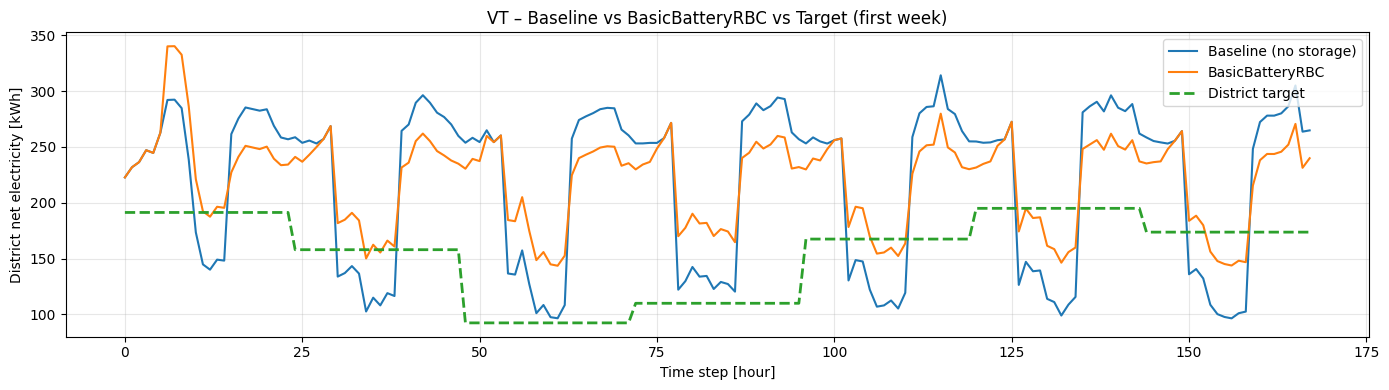

In [6]:
import matplotlib.pyplot as plt

week = 24 * 7
hours = np.arange(week)

plt.figure(figsize=(14,4))
plt.plot(hours, baseline_district_load[:week], label="Baseline (no storage)")
plt.plot(hours, district_load_rbc[:week], label=type(agent).__name__)
plt.plot(hours, district_target[:week], "--", label="District target", linewidth=2)

plt.xlabel("Time step [hour]")
plt.ylabel("District net electricity [kWh]")
plt.title(f"{CLIMATE} – Baseline vs {type(agent).__name__} vs Target (first week)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Evaluate Performance (KPIs)

These KPIs will be used for comparison across all CE1 participants.


## You're all set!

You now have:

- Installed CityLearn requirements 
- Loaded TX or VT scenario  
- Viewed district reference loads  
- Run a baseline RBC  
- Computed comparison KPIs  

If you run into any issue, please reach out in the **Annex 96 Slack**.

Happy experimenting! 🚀
